In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import time
import random
import torch
import os
import numpy as np
from torchvision.datasets import MNIST, SVHN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
from torch.utils.data import Dataset
from sklearn.svm import LinearSVC
from splice.splice import SPLICE

from copy import deepcopy

import sys

sys.path.append("../")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
data =  np.load(r"C:\Users\Harris_Lab\Projects\SPLICE\data\mnist\mnist_rotated_360.npz")

X = torch.Tensor(data["original"][:50000]).to(device)
Y = torch.Tensor(data["rotated"][:50000]).to(device)

X_val = (
    torch.Tensor(data["original"][50000:60000]).to(device).reshape(-1, 1, 28, 28)
)

Y_val = torch.Tensor(data["rotated"][50000:60000]).to(device).reshape(-1, 1, 28, 28)

X_test = torch.Tensor(data["original"][60000:]).to(device)
Y_test = torch.Tensor(data["rotated"][60000:]).to(device)
angles_test = data["angles"][60000:]
labels_test = data["labels"][60000:]

### True Private dimensionality

In [12]:
dims = [2,3,5,7,10]
n_shared = 30
n_privateA = 0

top2_var = np.zeros(5)

for dim in dims:
    print("dim: ", dim)

    if dim == 2:
        layers_msr = [32,32,64,128,256]
    else:
        layers_msr = [32,64,128,256]

    model = SPLICE(
        784,
        784,
        n_shared=n_shared,
        n_priv_a=n_privateA,
        n_priv_b=dim,
        layers_enc=[256, 128, 64, 32],
        layers_dec=[32, 64, 128, 256],
        layers_msr=layers_msr,
    ).to(device)

    print(model.load_state_dict(torch.load(r"../results/models/mnist/splice_isomap_mnist_%dD.pt" % dim)))

    private = model.F_b(Y_test).detach().cpu().numpy()

    pca = PCA(n_components=dim)
    pca.fit(private)

    # plt.figure()
    # plt.plot(np.arange(dim)+1, np.cumsum(pca.explained_variance_ratio_), marker='o')
    # plt.xlim(0, 10); plt.ylim(0, 1)

    # print(np.cumsum(pca.explained_variance_ratio_)[1])
    # print(dims.index(dim))

    top2_var[dims.index(dim)] = np.cumsum(pca.explained_variance_ratio_)[1]

dim:  2
<All keys matched successfully>
dim:  3
<All keys matched successfully>
dim:  5
<All keys matched successfully>
dim:  7
<All keys matched successfully>
dim:  10
<All keys matched successfully>


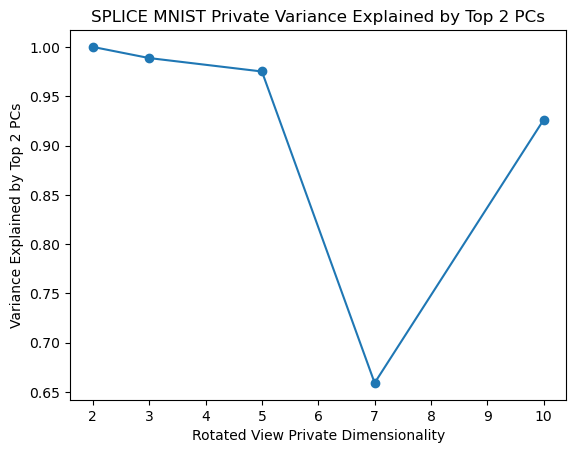

In [14]:
plt.plot(dims, top2_var, marker='o');
plt.title("SPLICE MNIST Private Variance Explained by Top 2 PCs")
plt.ylabel('Variance Explained by Top 2 PCs')
plt.xlabel('Rotated View Private Dimensionality')

plt.savefig("../figures/jmlr/SPLICE_MNIST_extra_dims_top2pc.svg", transparent=True, dpi=300)

### Cross reconstructions

In [15]:
def rot_digit(m, angle=-1):
    """
    Returns the digit/image "m" by a random angle [-45,45]deg
    clips it to MNIST size
    and returns it flattened into (28*28,) shape
    """
    if angle < 0:
        angle=np.random.rand()*360 #will lead to ambiguities because "6" = "9"

    m = m.reshape((28,28))
    tmp = rotate(m, angle=angle)
    xs, ys = tmp.shape
    xs = int(xs/2)
    ys = int(ys/2)
    rot_m = tmp[xs-14:xs+14,ys-14:ys+14]
    return rot_m.reshape((28*28,)), angle

In [23]:
dims = [2,3,5,7,10]
n_shared = 30
n_privateA = 0
wseed = 0

top2_var = np.zeros(5)

#digit and angle sources
digit_source = torch.Tensor(np.tile(data["original"][-10000:][2463].reshape(-1,784), [5,1])).to(device)
rot_angles = [36, 108, 180, 252, 324]
rot_inds = [264, 3910, 2463, 4756, 7293]
angle_sources = np.zeros((5,784))

for i, angle in enumerate(rot_angles):
    angle_sources[i] = rot_digit(data["original"][-10000:][rot_inds[i]], angle=angle)[0]
angle_sources = torch.Tensor(angle_sources).reshape(-1,784).to(device)


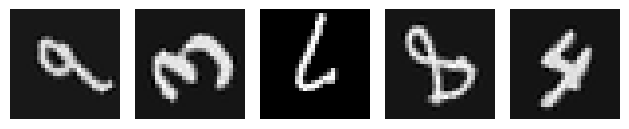

In [19]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(angle_sources[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray")
    # plt.savefig(f"../../figures/arxiv_figures/Lee_cross_rec_{i}.png", transparent=True, dpi=300)
    plt.axis("off");

plt.tight_layout()


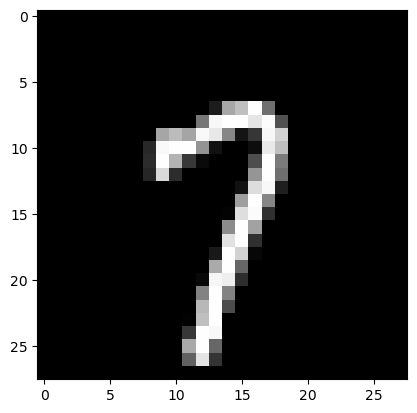

In [20]:
plt.imshow(data["original"][-10000:][2463].reshape(28,28), cmap="gray")

dim:  2
<All keys matched successfully>
dim:  3
<All keys matched successfully>
dim:  5
<All keys matched successfully>
dim:  7
<All keys matched successfully>
dim:  10
<All keys matched successfully>


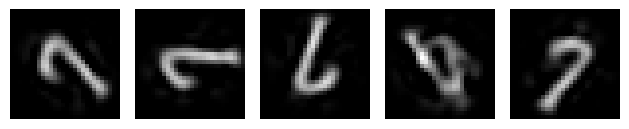

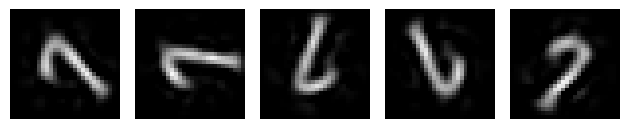

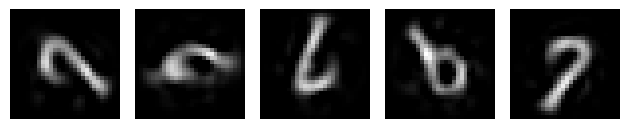

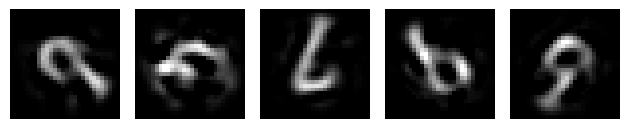

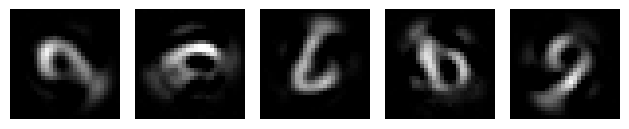

In [25]:
for dim in dims:
    print("dim: ", dim)

    if dim == 2:
        layers_msr = [32,32,64,128,256]
    else:
        layers_msr = [32,64,128,256]

    model = SPLICE(
        784,
        784,
        n_shared=n_shared,
        n_priv_a=n_privateA,
        n_priv_b=dim,
        layers_enc=[256, 128, 64, 32],
        layers_dec=[32, 64, 128, 256],
        layers_msr=layers_msr,
    ).to(device)

    print(model.load_state_dict(torch.load(r"../results/models/mnist/splice_isomap_mnist_%dD.pt" % dim)))

    shared_cross = model.F_a2b(digit_source)
    private_cross = model.F_b(angle_sources)

    cross_rec = model.G_b(torch.cat((private_cross, shared_cross), dim=-1))

    plt.figure()
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(cross_rec[i].detach().cpu().numpy().squeeze().reshape(28, 28), cmap="gray", vmin=0, vmax=1)
        plt.axis("off");

    plt.tight_layout()
    plt.savefig("../figures/jmlr/SPLICE_%ddim_cross_rec.svg" % (dim), transparent=True, dpi=300)



### SVM for digit identity on privates

In [27]:
Y.shape

torch.Size([50000, 1, 28, 28])

In [29]:
dims = [2,3,5,7,10]
private_svm_acc = np.zeros(5)
chance_svm_acc = np.zeros((5,500))

for dim in dims:
    print("dim: ", dim)
    if dim == 2:
        layers_msr = [32,32,64,128,256]
    else:
        layers_msr = [32,64,128,256]

    model = SPLICE(
        784,
        784,
        n_shared=n_shared,
        n_priv_a=n_privateA,
        n_priv_b=dim,
        layers_enc=[256, 128, 64, 32],
        layers_dec=[32, 64, 128, 256],
        layers_msr=layers_msr,
    ).to(device)

    print(model.load_state_dict(torch.load(r"../results/models/mnist/splice_isomap_mnist_%dD.pt" % dim)))

    private = model.F_b(Y).detach().cpu().numpy()
    
    private_test = model.F_b(Y_test).detach().cpu().numpy()
    
    svm = LinearSVC(max_iter=10000)
    svm.fit(private[:20000], data["labels"][:20000].astype(int))
    private_svm_acc[dims.index(dim)] = svm.score(private_test, data["labels"][60000:].astype(int))

    # permutation test
    for i in range(500):
        print(i, end='\r')
        private = np.roll(private[:20000], 1, axis=0)
        private_test = np.roll(private_test, 1, axis=0)
        svm.fit(private, data["labels"][:20000].astype(int))
        chance_svm_acc[dims.index(dim),i] = svm.score(private_test, data["labels"][60000:].astype(int))


dim:  2
<All keys matched successfully>


c:\Users\Harris_Lab\miniconda3\envs\splice\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [26]:
private_svm_acc

array([0.1116, 0.1158, 0.1198, 0.1316, 0.1401])

In [28]:
private_svm_pvals = np.zeros(5)
for i in range(5):
    private_svm_pvals[i] = (np.sum(private_svm_acc[i] < chance_svm_acc[i])) / 500

private_svm_pvals

array([0.852, 0.008, 0.   , 0.   , 0.   ])

### theta-related variance in privates

In [30]:
dims = [2,3,5,7,10]
shifts = np.load(r"C:\Users\Harris_Lab\Projects\SPLICE\results\mnist_test5k_shifts.npy")
var_explained_by_theta = np.zeros(5)

for dim in dims:
    print("dim: ", dim)
    if dim == 2:
        layers_msr = [32,32,64,128,256]
    else:
        layers_msr = [32,64,128,256]

    model = SPLICE(
        784,
        784,
        n_shared=n_shared,
        n_priv_a=n_privateA,
        n_priv_b=dim,
        layers_enc=[256, 128, 64, 32],
        layers_dec=[32, 64, 128, 256],
        layers_msr=layers_msr,
    ).to(device)

    print(model.load_state_dict(torch.load(r"../results/models/mnist/splice_isomap_mnist_%dD.pt" % dim)))

    private_test = model.F_b(Y_test).detach().cpu().numpy()

    window_vars = []

    shifted_angles = (data["angles"][-10000:][:5000]+shifts) % 360
    full_var = np.var(private_test[:5000], axis=0)
    width = 5

    for i in range(360):
        window = private_test[:5000][(shifted_angles > i) & (shifted_angles < i+width)]
        var = np.var(window, axis=0)/full_var
        window_vars.append(var.mean())
    var_explained_by_theta[dims.index(dim)] = 1 - np.mean(window_vars)
    

dim:  2
<All keys matched successfully>
dim:  3
<All keys matched successfully>
dim:  5
<All keys matched successfully>
dim:  7
<All keys matched successfully>
dim:  10
<All keys matched successfully>


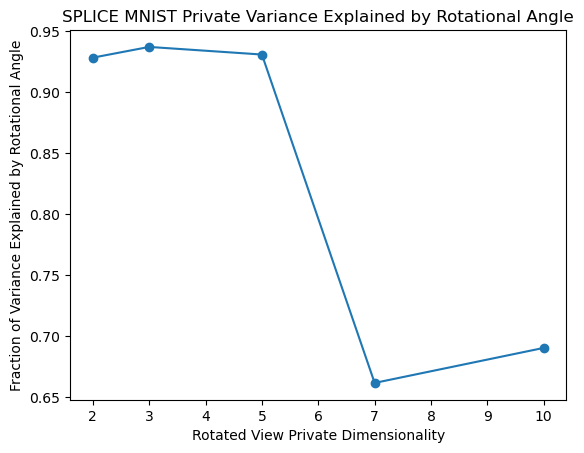

In [31]:
# USE THIS ONE

plt.plot(dims, var_explained_by_theta, marker='o');
plt.title("SPLICE MNIST Private Variance Explained by Rotational Angle")
plt.ylabel("Fraction of Variance Explained by Rotational Angle")
plt.xlabel('Rotated View Private Dimensionality')

plt.savefig("../figures/jmlr/SPLICE_MNIST_extra_dims_theta-var-exp.svg", transparent=True, dpi=300)